 # GOLUB use case

In [1]:
library("binom") 
library("evaluomeR")
library("cancerclass")
library("dplyr")
library("caret")
library("MLmetrics")
library("ggplot2")
library("ggrepel")
library("reshape2")

options(scipen=10)

Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which

In [2]:
packageVersion("evaluomeR")

[1] '1.7.10'

# Table of contents
* [Dataset](#dataset)
    * [Removing highly correlated metrics](#correlated)
    * [Top 100](#top)
* [evaluomeR - optimal $k$ analysis](#evaluomeR)
    * [Stability plotting](#evaluomeR_stab_plot)
    * [Quality plotting](#evaluomeR_qual_plot)
* [PCA](#pca)
* [Sensitivity](#sensitivity)
* [CER](#cer)

# Dataset <a class="anchor" id="dataset"></a>

In [3]:
load("data/leukemia.RData")
golub = as.data.frame(leukemia)
head(golub)

Case,AFFX.HUMRGE.M10098_5_at,AFFX.HUMRGE.M10098_M_at,AFFX.HUMRGE.M10098_3_at,AFFX.M27830_5_at,D13639_at,D83735_at,D83920_at,D87433_at,D88270_at,...,X65965_s_at,X76223_s_at,AF000424_s_at,M21305_at,U57341_at,HG3576.HT3779_f_at,U01317_cds4_at,M15395_at,M34516_at,Class
B1,4.16250,3.98847,3.93090,3.82930,3.67274,2.00000,2.00000,2.0000,3.29336,...,2.83059,2.00000,3.49914,2.91960,2.30750,3.92536,2.07555,2.23553,3.82595,B
T1,2.78888,2.06070,3.18127,3.34537,3.52724,3.04218,3.35545,2.0000,2.29667,...,3.40926,3.96624,3.71533,2.00000,2.69810,3.25479,2.00000,3.19535,3.46195,T
T2,3.75351,3.51481,3.56443,3.52179,2.00000,2.89321,2.31175,2.0000,2.76268,...,2.52763,4.20412,2.85003,3.38364,2.64345,2.00000,2.23553,2.50379,2.00000,T
B2,3.68574,3.36040,3.40976,3.48544,2.00432,2.00000,2.00000,2.0000,3.68851,...,2.43457,2.00000,2.00000,2.79029,2.98632,3.42911,2.59660,2.37658,3.14364,B
B3,3.10857,3.43632,2.49969,3.05308,3.10585,2.00000,2.30750,2.4014,3.52930,...,2.56820,2.00000,2.73640,2.45637,2.22272,3.37014,2.09342,3.03383,3.36399,B
T3,3.61784,3.43823,3.38093,3.59173,2.00000,2.00000,3.18639,2.0000,2.00000,...,2.50651,4.13117,3.25888,2.00000,2.07918,2.00000,2.00000,3.01536,2.00000,T


Three types of classes within the dataset: **B**, **T** and **M**.

In [4]:
unique(golub["Class"])

,Class
1,B
2,T
28,M


*Further information regarding GOLUB in [cancerclass](https://rdrr.io/bioc/cancerclass/man/GOLUB.html) package.*

Here, we prepare the GOLUB dataset for the analysis, in order to do so, we remove non-numeric columns:

In [5]:
golub["Class"] = NULL # leukemia
golub["sample"] = NULL
golub["type"] = NULL
golub["FAB"] = NULL
golub["gender"] = NULL

In [6]:
head(golub)

Case,AFFX.HUMRGE.M10098_5_at,AFFX.HUMRGE.M10098_M_at,AFFX.HUMRGE.M10098_3_at,AFFX.M27830_5_at,D13639_at,D83735_at,D83920_at,D87433_at,D88270_at,...,X00437_s_at,X65965_s_at,X76223_s_at,AF000424_s_at,M21305_at,U57341_at,HG3576.HT3779_f_at,U01317_cds4_at,M15395_at,M34516_at
B1,4.16250,3.98847,3.93090,3.82930,3.67274,2.00000,2.00000,2.0000,3.29336,...,2.18469,2.83059,2.00000,3.49914,2.91960,2.30750,3.92536,2.07555,2.23553,3.82595
T1,2.78888,2.06070,3.18127,3.34537,3.52724,3.04218,3.35545,2.0000,2.29667,...,4.10690,3.40926,3.96624,3.71533,2.00000,2.69810,3.25479,2.00000,3.19535,3.46195
T2,3.75351,3.51481,3.56443,3.52179,2.00000,2.89321,2.31175,2.0000,2.76268,...,2.00000,2.52763,4.20412,2.85003,3.38364,2.64345,2.00000,2.23553,2.50379,2.00000
B2,3.68574,3.36040,3.40976,3.48544,2.00432,2.00000,2.00000,2.0000,3.68851,...,2.00000,2.43457,2.00000,2.00000,2.79029,2.98632,3.42911,2.59660,2.37658,3.14364
B3,3.10857,3.43632,2.49969,3.05308,3.10585,2.00000,2.30750,2.4014,3.52930,...,2.00000,2.56820,2.00000,2.73640,2.45637,2.22272,3.37014,2.09342,3.03383,3.36399
T3,3.61784,3.43823,3.38093,3.59173,2.00000,2.00000,3.18639,2.0000,2.00000,...,4.20412,2.50651,4.13117,3.25888,2.00000,2.07918,2.00000,2.00000,3.01536,2.00000


## Removing highly correlated metrics <a class="anchor" id="correlated"></a>
We address the issue of multicorrelation by identifying and removing highly correlated metrics (absolute correlation, 1) from our dataset. First, we exclude the first column from the dataset `golub`, where the column `Case` is. We then compute the correlation matrix R for data using the `cor` function. To pinpoint the metrics that exhibit perfect correlation (correlation coefficient of 1 or -1), we make use of the `findCorrelation` function from the `caret` package, setting a cutoff of 1. This function returns the names of the variables that are highly correlated, if any.

In [7]:
data = golub[-1]
R = cor(data)
head(R)

,AFFX.HUMRGE.M10098_5_at,AFFX.HUMRGE.M10098_M_at,AFFX.HUMRGE.M10098_3_at,AFFX.M27830_5_at,D13639_at,D83735_at,D83920_at,D87433_at,D88270_at,D88422_at,...,X00437_s_at,X65965_s_at,X76223_s_at,AF000424_s_at,M21305_at,U57341_at,HG3576.HT3779_f_at,U01317_cds4_at,M15395_at,M34516_at
AFFX.HUMRGE.M10098_5_at,1.00000000,0.94528825,0.940680900,0.77912853,-0.1973053,0.020456906,-0.1096624,-0.01383022,-0.016918622,-0.1411501,...,0.14065855,-0.02998448,0.21601689,-0.02605452,-0.330429874,0.01579724,-0.2972520,-0.070312138,-0.21883293,0.015992406
AFFX.HUMRGE.M10098_M_at,0.94528825,1.00000000,0.910579713,0.71505370,-0.2134307,-0.035661949,-0.1675192,-0.03848112,0.056532531,-0.1995248,...,0.11476015,-0.13127374,0.18020996,-0.07453643,-0.235098965,-0.09126448,-0.2673512,-0.141429954,-0.26065292,-0.040604229
AFFX.HUMRGE.M10098_3_at,0.94068090,0.91057971,1.000000000,0.78440879,-0.2103221,0.004372542,-0.1382389,-0.07123307,-0.006921601,-0.2050484,...,0.22623819,-0.06758595,0.30290886,-0.04552536,-0.287973093,-0.02285115,-0.3739390,-0.116550351,-0.30384555,-0.063379185
AFFX.M27830_5_at,0.77912853,0.71505370,0.784408790,1.00000000,-0.1259413,-0.058320081,-0.2053630,-0.09539274,0.191117767,-0.2962061,...,0.07777391,0.01270773,0.16755869,-0.16011183,-0.152058167,0.04371082,-0.1734089,-0.071983122,-0.33546790,-0.092884086
D13639_at,-0.19730530,-0.21343065,-0.210322067,-0.12594134,1.0000000,0.214746419,-0.2134899,-0.06713339,0.088769297,-0.1301940,...,-0.18625093,0.15779702,-0.25359480,0.09809683,0.088825194,0.22350988,0.4512396,0.200613737,-0.02989658,0.001768725
D83735_at,0.02045691,-0.03566195,0.004372542,-0.05832008,0.2147464,1.000000000,0.1859050,0.18106050,-0.243976369,0.1595494,...,0.16543140,0.04991622,-0.02040268,0.28615603,-0.002396266,0.13131286,0.1734750,-0.007277627,0.35960233,0.164954817


In [8]:
cor_metrics = findCorrelation(R, cutoff = 1, verbose = FALSE, names=TRUE)
length(cor_metrics)

[1] 0

Finally, we use `length(cor_metrics)` to determine the number of these highly correlated metrics. As this number is 0, we assess there are no highly correlated metrics.

## Top 100 <a class="anchor" id="top"></a>
We now filter the metrics for including only the top 100 with the greatest variance, as these metrics have the most significant impact on clustering.

In [9]:
variance = sort(sapply(golub[-1], var,na.rm = TRUE), decreasing = TRUE)  # Sorted gene variance
gene_var = as.data.frame(variance)
gene_var["gene"] = rownames(gene_var)
head(gene_var)

,variance,gene
X82240_rna1_at,0.7720814,X82240_rna1_at
M27891_at,0.6621002,M27891_at
M26311_s_at,0.6585567,M26311_s_at
AFFX.HUMRGE.M10098_5_at,0.6396886,AFFX.HUMRGE.M10098_5_at
Y00787_s_at,0.6343951,Y00787_s_at
M84526_at,0.6198290,M84526_at


In [10]:
top_number = 100
top_genes = gene_var[c(1:top_number), ]
head(top_genes)

,variance,gene
X82240_rna1_at,0.7720814,X82240_rna1_at
M27891_at,0.6621002,M27891_at
M26311_s_at,0.6585567,M26311_s_at
AFFX.HUMRGE.M10098_5_at,0.6396886,AFFX.HUMRGE.M10098_5_at
Y00787_s_at,0.6343951,Y00787_s_at
M84526_at,0.6198290,M84526_at


In [11]:
gene_list = as.list(top_genes["gene"])
top_gene_list = unlist(setdiff(gene_list, names(golub)))
# Top 100 metrics (genes)
top_gene_list

[1] "X82240_rna1_at"          "M27891_at"              
  [3] "M26311_s_at"             "AFFX.HUMRGE.M10098_5_at"
  [5] "Y00787_s_at"             "M84526_at"              
  [7] "M19507_at"               "D88270_at"              
  [9] "M63438_s_at"             "M28130_rna1_s_at"       
 [11] "AFFX.HUMRGE.M10098_M_at" "M12886_at"              
 [13] "M91036_rna1_at"          "AFFX.HUMRGE.M10098_3_at"
 [15] "AFFX.M27830_5_at"        "X00437_s_at"            
 [17] "M21005_at"               "M87789_s_at"            
 [19] "M58459_at"               "M11722_at"              
 [21] "U01317_cds4_at"          "M21305_at"              
 [23] "M27783_s_at"             "L33930_s_at"            
 [25] "J04164_at"               "J04456_at"              
 [27] "X58529_at"               "U89922_s_at"            
 [29] "M21119_s_at"             "M25079_s_at"            
 [31] "M89957_at"               "Z83821_cds2_at"         
 [33] "M57710_at"               "M38690_at"              
 [35] "M57466_s_at"             "X05908_at"              
 [37] "X77737_at"               "M34516_at"              
 [39] "M91438_at"               "M96326_rna1_at"         
 [41] "U05259_rna1_at"          "X76223_s_at"            
 [43] "K01911_at"               "D88422_at"              
 [45] "U05255_s_at"             "X04500_at"              
 [47] "HG3576.HT3779_f_at"      "X95735_at"              
 [49] "X64072_s_at"             "D83735_at"              
 [51] "D83920_at"               "M21904_at"              
 [53] "J03909_at"               "AF000424_s_at"          
 [55] "Z23090_at"               "D13639_at"              
 [57] "J04102_at"               "U57341_at"              
 [59] "M15395_at"               "Z84721_cds2_at"         
 [61] "M38591_at"               "D87433_at"              
 [63] "U46499_at"               "X17042_at"              
 [65] "M63573_at"               "U09770_at"              
 [67] "U20734_s_at"             "M94345_at"              
 [69] "M23178_s_at"             "M11717_rna1_at"         
 [71] "M57731_s_at"             "J03077_s_at"            
 [73] "HG987.HT987_at"          "U02687_at"              
 [75] "L08895_at"               "M12759_at"              
 [77] "M34996_s_at"             "M13560_s_at"            
 [79] "M74719_at"               "X59871_at"              
 [81] "M92934_at"               "U23852_s_at"            
 [83] "U50743_at"               "U60644_at"              
 [85] "U10485_at"               "Z22548_at"              
 [87] "L20971_at"               "M33882_at"              
 [89] "J04615_at"               "X62744_at"              
 [91] "Z69881_at"               "M16279_at"              
 [93] "M21624_at"               "U02020_at"              
 [95] "M16336_s_at"             "L19686_rna1_at"         
 [97] "X65965_s_at"             "X03934_at"              
 [99] "M28826_at"               "M30703_s_at"

In [12]:
top_golub = golub[, top_gene_list]
top_golub["labels"] = rownames(top_golub)
top_golub = top_golub[ , c("labels", names(top_golub)[names(top_golub) != "labels"])] 

The dataframe `top_golub` contains 100 genes (metrics) which provides the most variance.

In [13]:
head(top_golub)

labels,X82240_rna1_at,M27891_at,M26311_s_at,AFFX.HUMRGE.M10098_5_at,Y00787_s_at,M84526_at,M19507_at,D88270_at,M63438_s_at,...,Z69881_at,M16279_at,M21624_at,U02020_at,M16336_s_at,L19686_rna1_at,X65965_s_at,X03934_at,M28826_at,M30703_s_at
1,4.16170,2.48144,2.00000,4.16250,2.52244,2.0000,2.0000,3.29336,3.75143,...,3.24699,3.48841,2.43457,2.24551,2.00000,2.89487,2.83059,2.79449,2.00000,2
2,2.00000,3.13290,3.64856,2.78888,3.72795,2.0000,2.0000,2.29667,3.68646,...,3.30428,4.01932,4.07185,3.05690,3.31513,3.86094,3.40926,3.88434,2.00000,2
3,2.00000,2.40483,2.88930,3.75351,2.47857,2.0000,2.0000,2.76268,2.00000,...,3.55096,3.97211,2.26007,2.06070,3.56384,3.79616,2.52763,4.05312,3.94379,2
4,3.71659,2.00000,2.19590,3.68574,2.38202,2.0000,2.0000,3.68851,2.00000,...,2.91803,3.17406,2.00000,2.00000,2.00000,2.79449,2.43457,2.67578,2.00000,2
5,3.77772,2.00000,3.33746,3.10857,2.00000,2.4624,2.9722,3.52930,2.83696,...,3.17493,3.67596,2.00000,2.33646,2.00000,3.78810,2.56820,2.53782,2.00000,2
6,2.00000,3.06744,3.20737,3.61784,2.33244,2.0000,2.0000,2.00000,2.00000,...,3.41597,3.94655,2.00000,2.00000,3.50947,3.55425,2.50651,3.85485,3.69522,2


# evaluomeR - optimal $k$ analysis <a class="anchor" id="evaluomeR"></a>

In this Section, evaluomeR executes an optimal $k$ analysis. First, stabilities and qualities are calculated, considering all the metrics in the dataset. The $k$ range is $k \in [3,10]$ and the clustering method is `clara`.

In [14]:
seed = 13606
k.range=c(3,10)
cbi = "clara"
top_golub = golub
colnames(top_golub)[colnames(top_golub) == 'Case'] <- 'Description'

Stability calculation with $k \in [3,10]$ and `clara`:

In [15]:
stab_range = stabilityRange(data=top_golub, k.range=k.range, 
                            bs=100, seed=seed,
                            all_metrics=TRUE,
                            cbi=cbi)
stab = standardizeStabilityData(stab_range)


Data loaded.
Number of rows: 72
Number of columns: 101


Processing all metrics, 'merge', in dataframe (100)
	Calculation of k = 3
	Calculation of k = 4
	Calculation of k = 5
	Calculation of k = 6
	Calculation of k = 7
	Calculation of k = 8
	Calculation of k = 9
	Calculation of k = 10


## Stability plotting <a class="anchor" id="evaluomeR_stab_plot"></a>

Stability plot

In [16]:
rownames(stab) = c("stab_clara")
stab$Metric = rownames(stab)
stab$Method = "clara"
stab_melt = melt(stab, id.vars = c("Metric", "Method"))

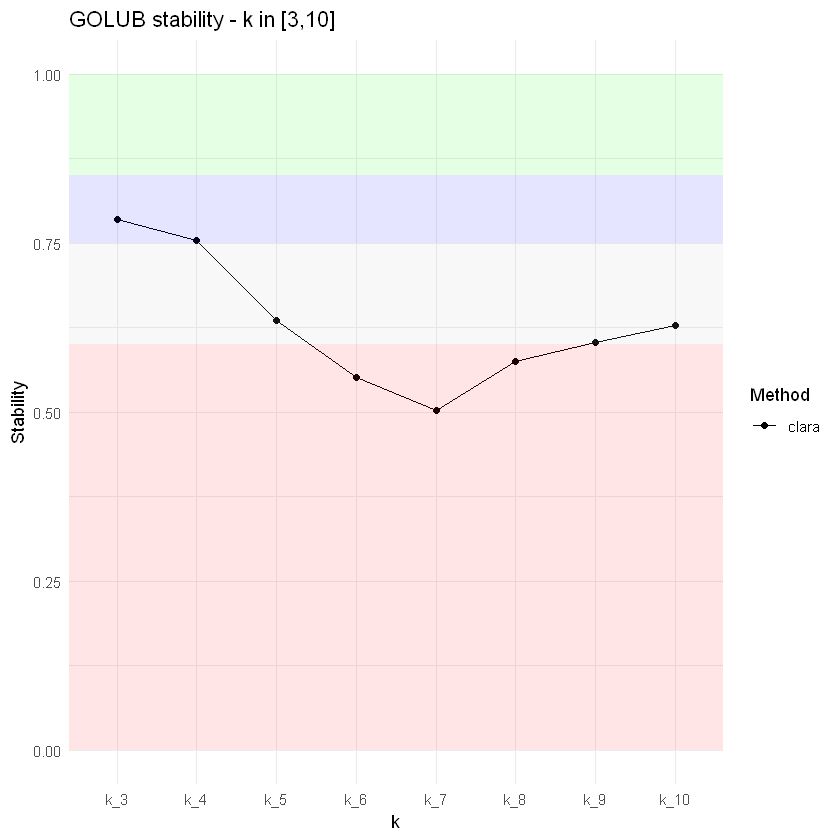

In [17]:
# Color
grayscale_colors <- c("black", "darkgray", "gray", "lightgray", "white")

# Base ggplot
p <- ggplot(stab_melt, aes(x = variable, y = value, color = Method, group = Method)) +
  geom_point() +
  geom_line() +
  scale_color_manual(values = grayscale_colors) +
  labs(
    title = paste0('GOLUB stability - k in [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Stability'
  ) +
  scale_y_continuous(limits = c(0, 1)) +
  theme_minimal()

# Adding rectangles
p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.85, ymax = 1, alpha = 0.1, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.75, ymax = 0.85, alpha = 0.1, fill = "blue") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.6, ymax = 0.75, alpha = 0.1, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0, ymax = 0.6, alpha = 0.1, fill = "red")



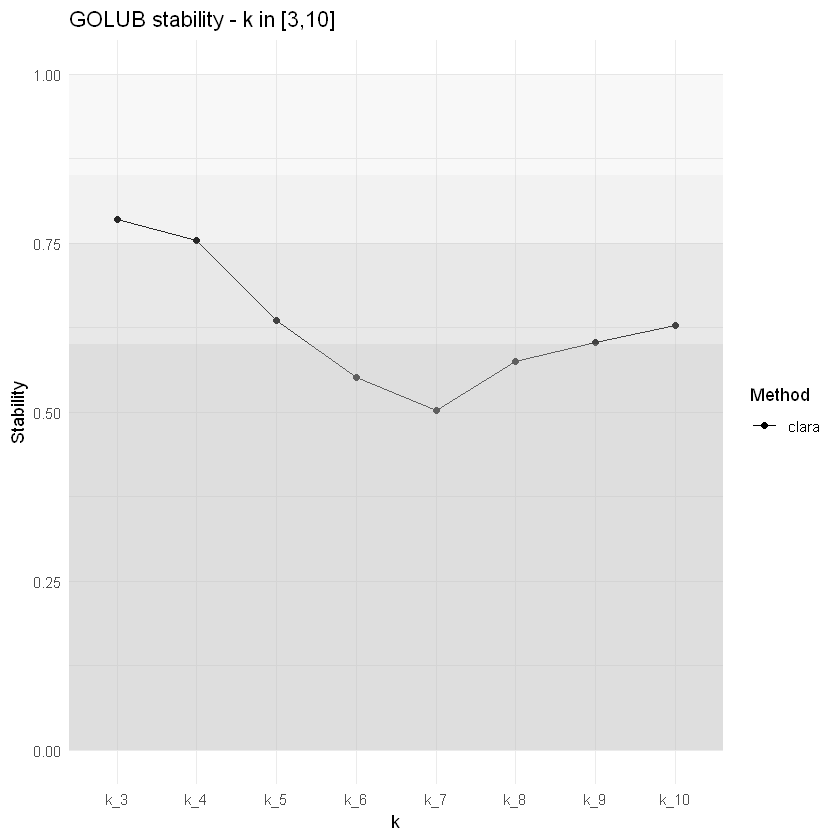

In [18]:
# Grayscale

# Define the grayscale palette
grayscale_colors <- c("black", "darkgray", "gray", "lightgray", "white")

# Base ggplot
p <- ggplot(stab_melt, aes(x = variable, y = value, color = Method, group = Method)) +
  geom_point() +
  geom_line() +
  scale_color_manual(values = grayscale_colors) +
  labs(
    title = paste0('GOLUB stability - k in [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Stability'
  ) +
  scale_y_continuous(limits = c(0, 1)) +
  theme_minimal()

# Adding grayscale rectangles
p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.85, ymax = 1, alpha = 0.1, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.75, ymax = 0.85, alpha = 0.2, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.6, ymax = 0.75, alpha = 0.35, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0, ymax = 0.6, alpha = 0.5, fill = "gray")


Quality calculation with $k \in [3,10]$ and `clara`.

In [19]:
qual_range = qualityRange(data=top_golub, k.range=k.range, 
                            all_metrics=TRUE, seed=seed,
                            cbi=cbi)
qual = standardizeQualityData(qual_range)


Data loaded.
Number of rows: 72
Number of columns: 101


Processing all metrics, 'merge', in dataframe (100)
	Calculation of k = 3
	Calculation of k = 4
	Calculation of k = 5
	Calculation of k = 6
	Calculation of k = 7
	Calculation of k = 8
	Calculation of k = 9
	Calculation of k = 10


## Quality plotting <a class="anchor" id="evaluomeR_qual_plot"></a>

Quality plot

In [20]:
rownames(qual) = c("qual_clara")
qual$Metric = rownames(qual)
qual$Method = "qual"
qual_melt = melt(qual, id.vars = c("Metric", "Method"))

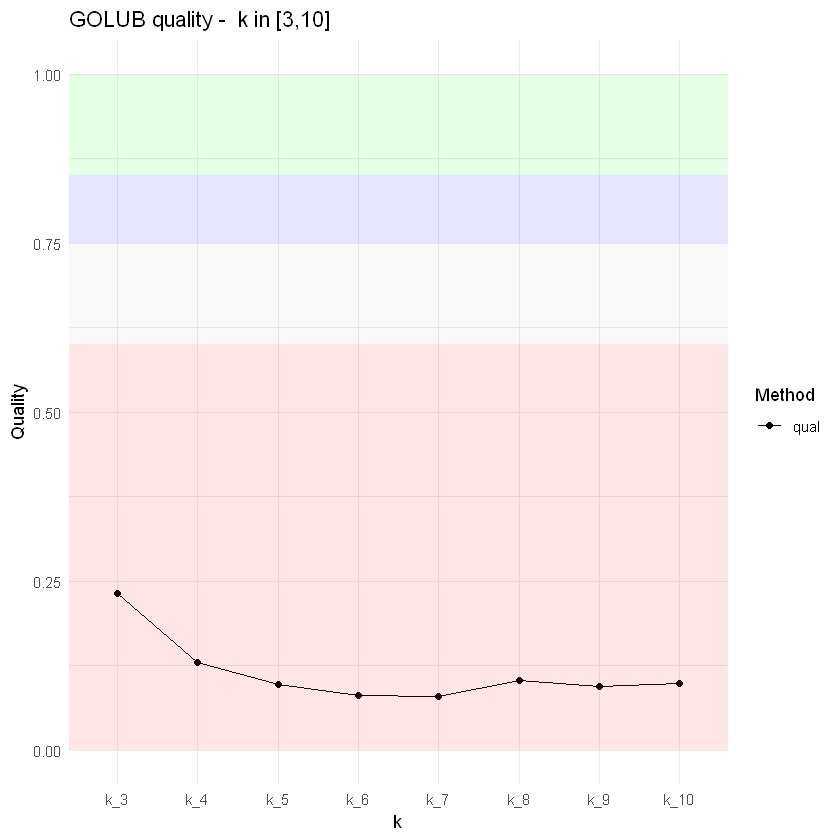

In [21]:
# Color
grayscale_colors <- c("black", "darkgray", "gray", "lightgray", "white")

# Base ggplot
p <- ggplot(qual_melt, aes(x = variable, y = value, color = Method, group = Method)) +
  geom_point() +
  geom_line() +
  scale_color_manual(values = grayscale_colors) +
  labs(
    title = paste0('GOLUB quality -  k in [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Quality'
  ) +
  scale_y_continuous(limits = c(0, 1)) +
  theme_minimal()

# Adding rectangles
p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.85, ymax = 1, alpha = 0.1, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.75, ymax = 0.85, alpha = 0.1, fill = "blue") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.6, ymax = 0.75, alpha = 0.1, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0, ymax = 0.6, alpha = 0.1, fill = "red")

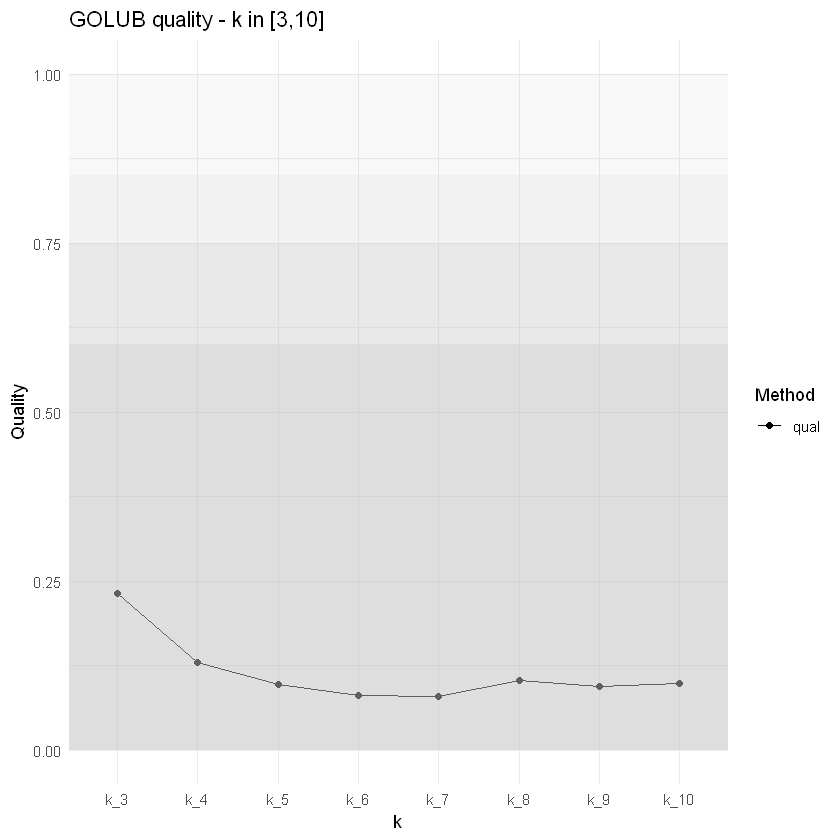

In [22]:
# Grayscale

grayscale_colors <- c("black", "darkgray", "gray", "lightgray", "white")


p <- ggplot(qual_melt, aes(x = variable, y = value, color = Method, group = Method)) +
  geom_point() +
  geom_line() +
  scale_color_manual(values = grayscale_colors) +
  labs(
    title = paste0('GOLUB quality - k in [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Quality'
  ) +
  scale_y_continuous(limits = c(0, 1)) +
  theme_minimal()

# Adding grayscale rectangles
p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.85, ymax = 1, alpha = 0.1, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.75, ymax = 0.85, alpha = 0.2, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.6, ymax = 0.75, alpha = 0.35, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0, ymax = 0.6, alpha = 0.5, fill = "gray")


Determining the optimal $k$ given the stabilities and qualities in `stab_range` and `qual_range` objects:

In [23]:
k_opt = getOptimalKValue(stab_range, qual_range, k.range= k.range)
optimal_k = k_opt$Global_optimal_k
optimal_k_str = paste0("k_", optimal_k)
print(paste0("Optimal k: ", optimal_k))

Processing metric: all_metrics

	Maximum stability and quality values matches the same K value: '3'



[1] "Optimal k: 3"


In [24]:
print(paste0("Stabilities and qualities per k with '", cbi, "' as clustering method"))
stab
qual
print(paste0("Stabily in k=", optimal_k,": ", stab[optimal_k_str]))
print(paste0("Quality in k=", optimal_k,": ", qual[optimal_k_str]))

[1] "Stabilities and qualities per k with 'clara' as clustering method"


,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10,Metric,Method
stab_clara,0.7853092,0.7537019,0.6352238,0.5512476,0.5027411,0.5753578,0.6026215,0.6276503,stab_clara,clara


,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10,Metric,Method
qual_clara,0.2320141,0.1299018,0.09750963,0.08118129,0.07984548,0.1031934,0.09457494,0.09856581,qual_clara,qual


[1] "Stabily in k=3: 0.78530918036429"
[1] "Quality in k=3: 0.23201412622582"


# Clusters

In [25]:
# Internal method used to group individuals per cluster
individuals_per_cluster = function(qualityResult) {
    
  qual_df = as.data.frame(assay(qualityResult))
    

  cluster_pos_str = as.character(unlist(qual_df["Cluster_position"]))
  cluster_labels_str = as.character(unlist(qual_df["Cluster_labels"]))

  cluster_pos = as.list(strsplit(cluster_pos_str, ",")[[1]])
  cluster_labels = as.list(strsplit(cluster_labels_str, ",")[[1]])

  individuals_in_cluster = as.data.frame(cbind(cluster_labels, cluster_pos))
  colnames(individuals_in_cluster) = c("Individual", "InCluster")

  return(individuals_in_cluster)
}

In [26]:
cluster_individuals = individuals_per_cluster(assay(qual_range[optimal_k_str]))
print(paste0("CBI: ", cbi, " - k: ", optimal_k))
for (cluster_i in 1:optimal_k) {
    ind_in_cluster = paste(unlist(cluster_individuals[cluster_individuals$InCluster == cluster_i, ]["Individual"]), collapse = ",")
    print(paste("Cluster", cluster_i, ":", ind_in_cluster))
    print("")
}

[1] "CBI: clara - k: 3"
[1] "Cluster 1 : B1,B2,B3,B4,B5,B6,B7,B8,B9,B11,B12,B13,B14,B15,B16,B17,B18,B19,B20,B21,B22,B23,B24,B25,B26,B27,B28,B29,B30,B31,B32,B33,B34,B35,B36,B37,B38"
[1] ""
[1] "Cluster 2 : T1,T2,T3,T4,T5,T6,T7,T8"
[1] ""
[1] "Cluster 3 : B10,AML1,AML2,AML3,AML4,AML5,AML6,AML7,AML8,AML9,AML10,AML11,T9,AML12,AML13,AML14,AML15,AML16,AML17,AML18,AML19,AML20,AML21,AML22,AML23,AML24,AML25"
[1] ""


# PCA <a class="anchor" id="pca"></a>
We employ Principal Component Analysis (PCA) as a dimensionality reduction technique to facilitate the visualization of clusters within our dataset. PCA allow us to transform the original high-dimensional data into a lower-dimensional space, while preserving as much of the variability as possible.

In [27]:
top_golub["inCluster"] = as.numeric(cluster_individuals$InCluster)
pca_matrix = top_golub %>% select(-Description, -inCluster)
pca_result <- prcomp(pca_matrix, scale. = TRUE)
pca_df <- data.frame(pca_result$x)
pca_df$Cluster <- as.factor(top_golub$inCluster)
pca_df$Individual <- top_golub$Description
head(pca_df)

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,Cluster,Individual
-5.6600497,-0.9403696,0.6000786,-1.1199127,2.6200577,-4.0006269,0.6478649,-1.5370026,0.8663557,-2.17861488,...,-0.07198869,-0.10318543,-0.1122364,-0.122831348,-0.09263967,0.12561612,0.14561114,1.609823e-15,1,B1
2.6145853,5.2911219,-3.4964281,-6.1124251,1.5135496,-2.1009037,-0.1792254,1.3688467,0.7232899,-0.03349621,...,-0.16755027,0.10902101,0.1899106,0.004990702,-0.14932991,-0.03649268,0.01170500,1.998401e-15,2,T1
-2.1354183,11.4500703,-1.7966203,0.2247835,-0.2318787,1.4493604,0.6051338,-1.4108101,1.4127356,-0.69496786,...,0.17767414,-0.12685695,0.1752885,-0.102442206,0.07161699,-0.05849892,-0.04429441,7.771561e-16,2,T2
-4.9435629,-0.8109685,2.7399280,3.5519694,2.9668022,2.2383532,1.6639109,1.3761154,-0.1218088,1.29753519,...,0.01588035,-0.18295107,0.1511074,0.197330690,-0.01898182,0.02336472,-0.19335383,7.216450e-16,1,B2
-1.1240684,-1.5104914,3.8906659,-0.8401832,1.7507364,2.6570295,2.4860771,-0.1088313,-0.5550100,-1.10456455,...,-0.27438116,-0.09281758,0.1820926,0.225872452,0.06440574,-0.19662224,0.11929858,1.665335e-15,1,B3
-0.9140257,10.9820116,-1.1194102,-0.2948204,-0.1110053,0.8184759,1.6933997,-1.3191906,0.9914184,0.76006577,...,0.17655650,0.05443685,-0.1479246,0.151052951,0.23717942,0.06982347,0.30425593,4.440892e-16,2,T3


Warning message:
"The following aesthetics were dropped during statistical transformation: label.
i This can happen when ggplot fails to infer the correct grouping structure in
  the data.
i Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?"Warning message:
"ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps"

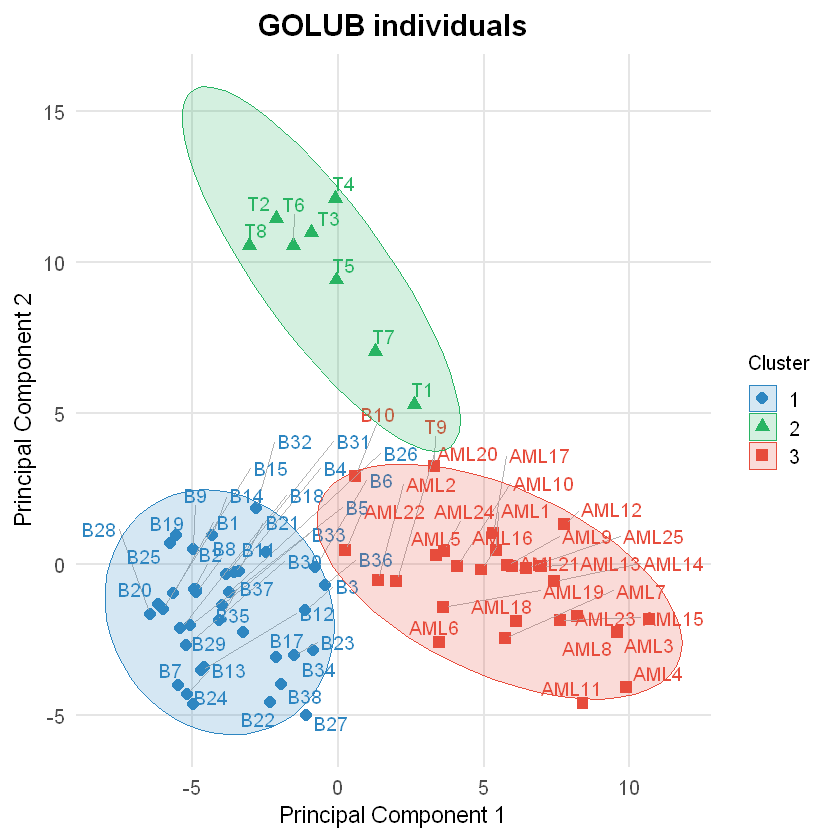

In [28]:
custom_colors <- c("#2E86C1", "#28B463", "#E74C3C", "#9B59B6", "#F1C40F", "#7F8C8D")

cluster_shapes <- c(16, 17, 15, 18, 19)

ggplot(pca_df, aes(x = PC1, y = PC2, shape = Cluster, color = Cluster, label = Individual)) +
  geom_point(size = 3) +
  geom_text_repel(
    vjust = 1,
    hjust = 1,
    size = 4,
    show.legend = FALSE,
    point.padding = 0.25,
    box.padding = 0.25,
    max.overlaps = 15,
    segment.color = "grey70",
    segment.size = 0.2
  ) +
  stat_ellipse(aes(fill = Cluster), level = 0.95, alpha = 0.2, geom = "polygon") +
  labs(
    title = "GOLUB individuals",
    x = "Principal Component 1",
    y = "Principal Component 2"
  ) +
  scale_shape_manual(values = cluster_shapes) +
  scale_color_manual(values = custom_colors) +
  scale_fill_manual(values = custom_colors) +
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text = element_text(size = 12),
    legend.position = "right",
    legend.title = element_text(size = 12),
    legend.text = element_text(size = 12),
    panel.grid.major = element_line(color = "grey90"),
    panel.grid.minor = element_blank()
  )


Warning message:
"The following aesthetics were dropped during statistical transformation: label.
i This can happen when ggplot fails to infer the correct grouping structure in
  the data.
i Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?"Warning message:
"ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps"

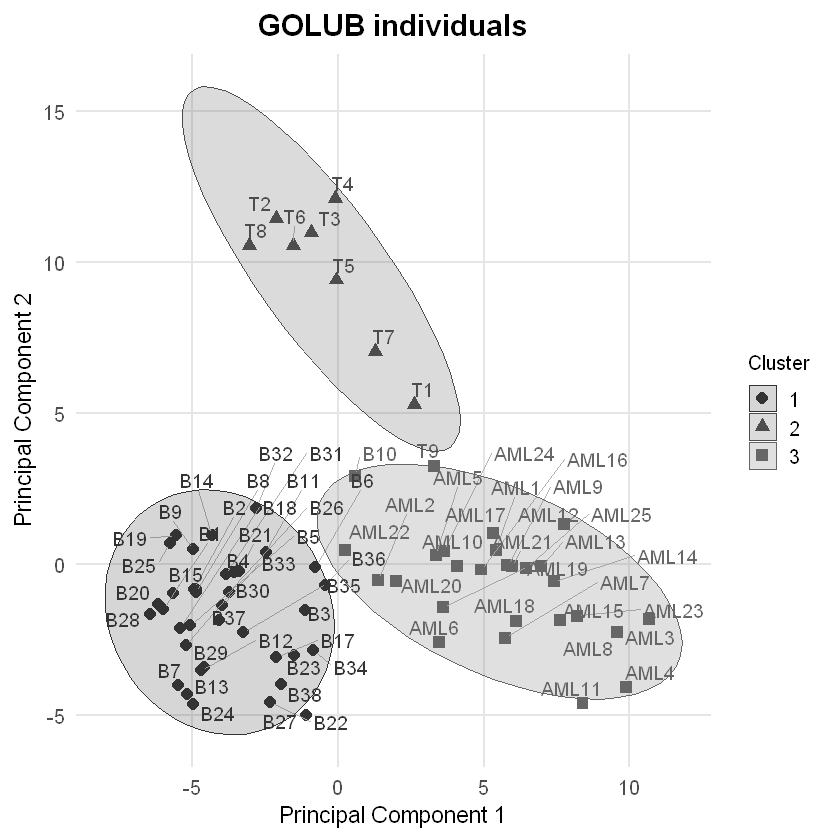

In [29]:
custom_colors <- c("gray20", "gray30", "gray40", "gray50", "black")

cluster_shapes <- c(16, 17, 15, 18, 19)

ggplot(pca_df, aes(x = PC1, y = PC2, shape = Cluster, color = Cluster, label = Individual)) +
  geom_point(size = 3) +
  geom_text_repel(
    vjust = 1, 
    hjust = 1, 
    size = 4,
    show.legend = FALSE,
    point.padding = 0.25,
    box.padding = 0.25,
    max.overlaps = 15,
    segment.color = "grey70",
    segment.size = 0.2
  ) +
  stat_ellipse(aes(fill = Cluster), level = 0.95, alpha = 0.2, geom = "polygon") +
  labs(
    title = "GOLUB individuals",
    x = "Principal Component 1",
    y = "Principal Component 2"
  ) +
  scale_shape_manual(values = cluster_shapes) +
  scale_color_manual(values = custom_colors) +
  scale_fill_manual(values = custom_colors) +
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text = element_text(size = 12),
    legend.position = "right",
    legend.title = element_text(size = 12),
    legend.text = element_text(size = 12),
    panel.grid.major = element_line(color = "grey90"),
    panel.grid.minor = element_blank()
  )


# Sensitivity <a class="anchor" id="sensitivity"></a>

In this Section we evaluate the sensitivity of our clustering using the `MLmetrics::Sensitivity` method. Sensitivity, or the true positive rate, measures the ability to correctly identify positive instances within the data. By focusing on sensitivity, we aim to ensure that our model effectively captures the relevant clusters, minimizing the number of false negatives. 

In [30]:
top_golub["Class"] = as.data.frame(leukemia)["Class"]
head(top_golub)[, c("Description", "Class")]

Description,Class
B1,B
T1,T
T2,T
B2,B
B3,B
T3,T


In [31]:
level_mapping <- c("B" = 1, "T" = 2, "M" = 3)
map_strings_to_numbers <- function(strings) {
  factorized <- factor(strings, levels = names(level_mapping))
  as.numeric(factorized)
}
# Map categories with cluster number
top_golub["Class_n"] = lapply(top_golub["Class"], map_strings_to_numbers)
# Table of prediction vs actual classification
head(top_golub[, c("Description", "Class", "Class_n")])

Description,Class,Class_n
B1,B,1
T1,T,2
T2,T,2
B2,B,1
B3,B,1
T3,T,2


In [32]:
# Getting a vector of prediction vs actual classification
actual = as.factor(as.vector(unlist(top_golub["Class_n"])))
predicted <- factor(as.vector(unlist(top_golub["inCluster"])))

print("actual")
actual
print("predicted")
predicted

[1] "actual"


[1] 1 2 2 1 1 2 1 1 2 2 2 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3
[39] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3
Levels: 1 2 3

[1] "predicted"


[1] 1 2 2 1 1 2 1 1 2 2 2 1 1 2 1 1 3 1 1 1 1 1 2 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3
[39] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3
Levels: 1 2 3

In [33]:
sens <- MLmetrics::Sensitivity(y_pred = predicted, y_true = actual)
sens = format(round(sens*100, 2), nsmall = 2)
print(paste0("Sensitivity: ", sens, "%"))

[1] "Sensitivity: 97.37%"


# CER <a class="anchor" id="cer"></a>
To assess the overall accuracy of our clustering, we compute the Classification Error Rate (CER) and compare it with the gold standard classification. CER represents the proportion of misclassified instances, thus providing a clear measure of the clustering performance in assigning individuals to the correct clusters.

In [34]:
cer <- CER(predicted, actual)
cer = format(round(cer*100, 2), nsmall = 2)
print(paste0("CER: ", cer, "%"))

[1] "CER: 3.76%"
